In [1]:
# MSDS 422, Section 58, Assignment 7, Alan Kessler
# Python 3.5 on Mac OS 10.13.5 edited in Atom & Jupyter Notebook
# Demonstrates use of Convolutional Layers in TensorFlow
# Heavily based on the code provided in the Geron text Chapter 10

import os
import time
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

# Constants used in test
width = 64
height = 64
nb_epochs = 50
b_size = 20
patience_threshold = 3
lr = 1e-3

# Sets logging to file
logging.basicConfig(level=logging.DEBUG,
                    filename='tf_train.log',
                    format='%(message)s')

# Add ability to stream items to console like print
console = logging.StreamHandler()
console.setLevel(logging.INFO)
logging.getLogger('').addHandler(console)

# Clears the log if it exists
log_exists = os.path.isfile('tf_train.log')
handler = logging.handlers.RotatingFileHandler('tf_train.log', mode='w',
                                               backupCount=0)
if log_exists:
    handler.doRollover()

# Log starting parameters
logging.debug("Constants")
logging.debug("---------")
logging.debug("Dimensions {:d} by {:d}".format(width, height))
logging.debug("Epochs {:d} of batch size {:d}".format(nb_epochs, b_size))
logging.debug("Early stopping patience of {:d}".format(patience_threshold))
logging.debug("Learning rate of {}".format(lr))
logging.debug("---------")


/Users/alankessler/anaconda/envs/drei/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
def read_image(file, fx, fy, channels):
    """Read in a single image and return a resized image"""

    # Define color or gray
    if channels == 3:
        # Read image based on number of channels
        img = cv2.imread(file, 1)

        # Convert colors for plotting purposes
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif channels == 1:
        # Read image based on number of channels
        img = cv2.imread(file, 0)
    else:
        raise ValueError("Invalid 'channels'. Use 1 (grayscale) or 3 (color)")

    # Resize image based on inputs
    img_resize = cv2.resize(img, (fx, fy), interpolation=cv2.INTER_CUBIC)

    return img_resize


def load_images(image_list, fx, fy, channels):
    """Read image and output as array"""

    # Initialize array of image values
    data = np.empty((len(image_list), fx, fy, channels), dtype=np.float32)

    # Iterate through loading images to arrays
    for i, file in enumerate(image_list):
        img = read_image(file, fx, fy, channels)

        if channels == 3:
            data[i] = cv2.normalize(img, None, alpha=0, beta=1,
                                    norm_type=cv2.NORM_MINMAX,
                                    dtype=cv2.CV_32F)
        else:
            img = cv2.normalize(img, None, alpha=0, beta=1,
                                norm_type=cv2.NORM_MINMAX,
                                dtype=cv2.CV_32F)
            # Add axis to make image fx x fy x 1
            data[i] = img[:, :, np.newaxis]
    return data


def shuffle_batch(X, y, batch_size):
    """From Geron text to create batches used in training"""
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch


# Convenience functions from the TensorFlow website
# Make model specification more concise
def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


def reset_graph():
    """Reset graph and random number seeds"""
    tf.reset_default_graph()
    tf.set_random_seed(2141)
    np.random.seed(27)


reset_graph()


In [3]:
# Directories containing assignment's subset of images
dir_dogs = "./cats_dogs_images/dogs/"
dir_cats = "./cats_dogs_images/cats/"

# Lists of file names of images with paths
# Checks that a file is an image given ds_store files found
img_nms_dogs = [dir_dogs+i for i in os.listdir(dir_dogs) if ".jpg" in i]
img_nms_cats = [dir_cats+i for i in os.listdir(dir_cats) if ".jpg" in i]

# Randomly shuffle images prior to partitioning
# No pattern assumed but shuffling to be sure
np.random.shuffle(img_nms_dogs)
np.random.shuffle(img_nms_cats)

# Partition 80% training, 10% validation, 10% testing
# Split to have as much available as possible for training given subset
img_nms_train = img_nms_dogs[0:800] + img_nms_cats[0:800]
img_nms_val = img_nms_dogs[800:900] + img_nms_cats[800:900]
img_nms_test = img_nms_dogs[900:] + img_nms_cats[900:]

# Randomly shuffle training and testing
# Model will used shuffle batching but useful check
np.random.shuffle(img_nms_train)
np.random.shuffle(img_nms_val)
np.random.shuffle(img_nms_test)

# Create labels
y_train = np.array([("dog." in i)*1 for i in img_nms_train])
y_val = np.array([("dog." in i)*1 for i in img_nms_val])
y_test = np.array([("dog." in i)*1 for i in img_nms_test])

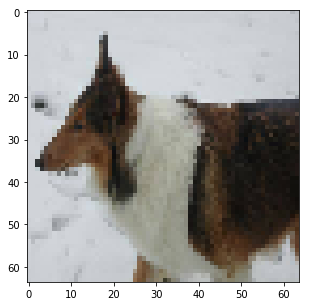

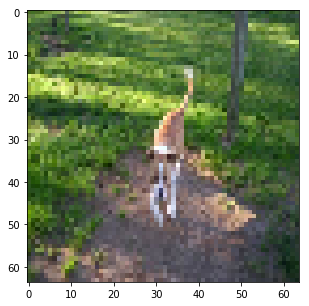

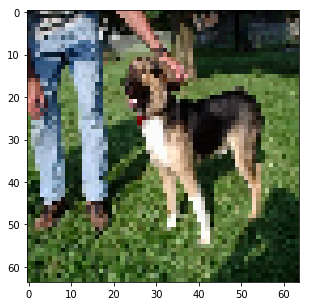

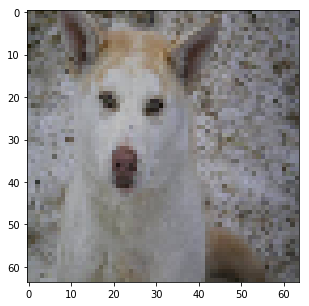

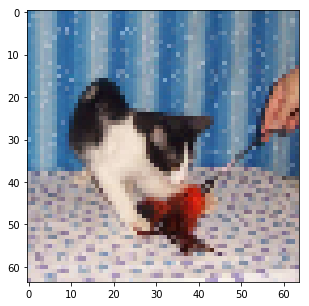

In [4]:
def show_pet_image(idx, fx, fy, channels):
    """Plot training images based on index"""
    img = read_image(img_nms_train[idx], fx, fy, channels)
    plt.figure(figsize=(10, 5))

    # Avoid greenish hue on grayscale images
    # Exception would have already been raised for invalid channel
    if channels == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=plt.cm.gray)
    plt.show()


# Plot 5 examples from the training data
for idx in range(0, 5):
    show_pet_image(idx, width, height, 3)

In [5]:
# Initialize metrics
metrics = {}
# Initialize metric names
names = ['Number of Conv Layers', 'Color', 'Time (s)',
         'Training Accuracy', 'Test Accuracy']

In [6]:
# Baseline Model - Based on Assignment 6 model
# 64x64x3 (color) data
# 2 hidden dense of 300 neurons each

logging.debug("Model 1 - Baseline")
logging.debug("------------------")

reset_graph()
channel_cnt = 3

# Load images
X_train = load_images(img_nms_train, width, height, channel_cnt)
X_val = load_images(img_nms_val, width, height, channel_cnt)
X_test = load_images(img_nms_test, width, height, channel_cnt)

# Start timer
start = time.clock()

# Set X and y placeholders
X = tf.placeholder(tf.float32, [None, width, height, channel_cnt], name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# Flatten out image when not using convolutional layers
with tf.name_scope('reshape'):
    x_image = tf.reshape(X, [-1, width*height*channel_cnt])

# Define the fully connected layers
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(x_image, 300, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, 300, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, 2, name="outputs")
    y_proba = tf.nn.softmax(logits)

# Loss is cross entropy
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

# Use optimizer to minimize cross entropy
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(lr)
    training_op = optimizer.minimize(loss)

# Evaluate on the basis of accuracy and log loss
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_proba, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    log_loss = tf.losses.log_loss(tf.one_hot(y, 2), y_proba)

# Train model and score on validation and test
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    # Initialize patience variables to prevent overfitting
    log_loss_prior = 99.99
    patience = 0
    
    for epoch in range(nb_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, b_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        # Generate fit statistics on training and validation data
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        log_loss_train = log_loss.eval(feed_dict={X: X_train, y: y_train})
        log_loss_val = log_loss.eval(feed_dict={X: X_val, y: y_val})
        logging.info("{}. Train Accuracy {:.4f}, Val Accuracy {:.4f}".format(str(epoch).zfill(2), acc_train, acc_val))
        logging.info("    Train Log Loss {:.4f}, Val Log Loss {:.4f}".format(log_loss_train, log_loss_val))
        
        # Stop early if validation log loss stops improving
        # Log loss is better than accuracy for measuring incremental improvement
        if log_loss_prior < log_loss_val:
            patience += 1
        if patience == patience_threshold:
            logging.info("Early Stop")
            break
        else:
            log_loss_prior = log_loss_val
    
    # Final accuracy evaluation on testing data
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})

# Record the clock time it takes
duration = time.clock() - start

metrics['Model 1'] = [0, 1, duration, acc_train, acc_test]
logging.debug("------------------")

00. Train Accuracy 0.5031, Val Accuracy 0.5050
    Train Log Loss 0.7750, Val Log Loss 0.7723
01. Train Accuracy 0.5069, Val Accuracy 0.5050
    Train Log Loss 0.7687, Val Log Loss 0.7576
02. Train Accuracy 0.5063, Val Accuracy 0.5100
    Train Log Loss 0.7537, Val Log Loss 0.7762
03. Train Accuracy 0.5219, Val Accuracy 0.5200
    Train Log Loss 0.7122, Val Log Loss 0.7334
04. Train Accuracy 0.6244, Val Accuracy 0.6100
    Train Log Loss 0.6422, Val Log Loss 0.6711
05. Train Accuracy 0.5656, Val Accuracy 0.4750
    Train Log Loss 0.6691, Val Log Loss 0.7349
06. Train Accuracy 0.6294, Val Accuracy 0.5300
    Train Log Loss 0.6567, Val Log Loss 0.6768
07. Train Accuracy 0.6500, Val Accuracy 0.5700
    Train Log Loss 0.6281, Val Log Loss 0.6938
Early Stop


In [7]:
# Specify Model:
#  Input
#  Conv 5x5, 32
#  Max Pooling 2x2
#  Conv 5x5, 64
#  Max Pooling 2x2
#  Optional Conv 5x5, 128
#  Optional Max Pooling 2x2
#  Fully Connected 300 neurons
#  Fully Connected 300 neurons
#  Dropout
#  Logit output layer

# Based heavily on examples from the TensorFlow website
def model_spec(x, fx, fy, channels, three_conv=False):
    """Specifies a NN given image input and
    whether to use two or three convolutional layers to
    returns logits and dropout probability"""
    
    # Reshape for input into convolutional layers
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, fx, fy, channels])

    # Convolutional Layer - 32 feature maps
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, channels, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # 2x2 Max Pooling Layer
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)

    # Convolutional Layer - 64 feature maps
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # 2x2 Max Pooling
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)
        
    if three_conv:
        # Convolutional Layer - 128 feature maps
        with tf.name_scope('conv3'):
            W_conv3 = weight_variable([5, 5, 64, 128])
            b_conv3 = bias_variable([128])
            h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

        # 2x2 Max Pooling
        with tf.name_scope('pool3'):
            h_pool3 = max_pool_2x2(h_conv3)
        
    # Flatten for fully connected layers
    with tf.name_scope('flatten'):
        if three_conv:
            h_pool_flat = tf.layers.flatten(h_pool3)
        else:
            h_pool_flat = tf.layers.flatten(h_pool2)

    # Dense Layer - 300 neurons
    with tf.name_scope('fc1'):
        if three_conv:
            W_fc1 = weight_variable([int((fx/8) * (fy/8)) * 128, 300])
        else:
            W_fc1 = weight_variable([int((fx/4) * (fy/4)) * 64, 300])
            
        b_fc1 = bias_variable([300])

        h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)
        
    # Dense Layer - 300 neurons
    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([300, 300])
        b_fc2 = bias_variable([300])

        h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
                
    # Dropout Layer - with argument for drop probability
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

    # Map the dense layer features to the classes
    with tf.name_scope('fc3'):
        W_fc3 = weight_variable([300, 2])
        b_fc3 = bias_variable([2])

        logits = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
        
    return logits, keep_prob


In [8]:
# Model 2 - Color with 2 conv layers

logging.debug("Model 2 - Color with 2 Conv Layers")
logging.debug("----------------------------------")

reset_graph()
channel_cnt = 3

# Load images
# Duplicative at times but is quick and avoid side effects later
X_train = load_images(img_nms_train, width, height, channel_cnt)
X_val = load_images(img_nms_val, width, height, channel_cnt)
X_test = load_images(img_nms_test, width, height, channel_cnt)

# Start timer
start = time.clock()

# Set X and y placeholders
X = tf.placeholder(tf.float32, [None, width, height, channel_cnt])
y = tf.placeholder(tf.int64, [None])

# Specify the model
logits, keep_prob = model_spec(X, width, height, channel_cnt, False)

# Loss is cross entropy
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y, logits=logits)
cross_entropy = tf.reduce_mean(cross_entropy)

# Using optimizer to minimize cross entropy
with tf.name_scope('optimizer'):
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

# Evaluate on the basis of accuracy and log loss
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
log_loss = tf.losses.log_loss(tf.one_hot(y, 2), tf.nn.softmax(logits))
                              
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Initialize patience variables to prevent overfitting
    log_loss_prior = 99.99
    patience = 0
    
    for epoch in range(nb_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, b_size):
            train_step.run(feed_dict={X: X_batch, y: y_batch, keep_prob: 0.5})
        
        # Generate fit statistics on training and validation data
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        log_loss_train = log_loss.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        log_loss_val = log_loss.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        logging.info("{}. Train Accuracy {:.4f}, Val Accuracy {:.4f}".format(str(epoch).zfill(2), acc_train, acc_val))
        logging.info("    Train Log Loss {:.4f}, Val Log Loss {:.4f}".format(log_loss_train, log_loss_val))
        
        # Stop early if validation log loss stops improving
        # Log loss is better than accuracy for measuring incremental improvement
        if log_loss_prior < log_loss_val:
            patience += 1
        if patience == patience_threshold:
            logging.info("Early Stop")
            break
        else:
            log_loss_prior = log_loss_val
    
    # Final accuracy evaluation on testing data
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, keep_prob: 1.0})

# Record the clock time it takes
duration = time.clock() - start

metrics['Model 2'] = [2, 1, duration, acc_train, acc_test]
logging.debug("-----------------------------")

00. Train Accuracy 0.6087, Val Accuracy 0.5600
    Train Log Loss 0.6610, Val Log Loss 0.6833
01. Train Accuracy 0.6894, Val Accuracy 0.5850
    Train Log Loss 0.6093, Val Log Loss 0.6739
02. Train Accuracy 0.7294, Val Accuracy 0.6300
    Train Log Loss 0.5817, Val Log Loss 0.6554
03. Train Accuracy 0.7881, Val Accuracy 0.5900
    Train Log Loss 0.4949, Val Log Loss 0.6864
04. Train Accuracy 0.7169, Val Accuracy 0.6050
    Train Log Loss 0.5113, Val Log Loss 0.7329
05. Train Accuracy 0.8388, Val Accuracy 0.6200
    Train Log Loss 0.3709, Val Log Loss 0.7050
06. Train Accuracy 0.8625, Val Accuracy 0.6200
    Train Log Loss 0.3198, Val Log Loss 0.7952
Early Stop


In [9]:
# Model 3 - Color with 3 conv layers

logging.debug("Model 3 - Color with 3 Conv Layers")
logging.debug("----------------------------------")

reset_graph()
channel_cnt = 3

# Load images
# Duplicative at times but is quick and avoid side effects later
X_train = load_images(img_nms_train, width, height, channel_cnt)
X_val = load_images(img_nms_val, width, height, channel_cnt)
X_test = load_images(img_nms_test, width, height, channel_cnt)

# Start timer
start = time.clock()

# Set X and y placeholders
X = tf.placeholder(tf.float32, [None, width, height, channel_cnt])
y = tf.placeholder(tf.int64, [None])

# Specify the model
logits, keep_prob = model_spec(X, width, height, channel_cnt, True)

# Loss is cross entropy
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y, logits=logits)
cross_entropy = tf.reduce_mean(cross_entropy)

# Using Adam optimizer to minimize cross entropy
with tf.name_scope('optimizer'):
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

# Evaluate on the basis of accuracy and log loss
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
log_loss = tf.losses.log_loss(tf.one_hot(y, 2), tf.nn.softmax(logits))
                              
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Initialize patience variables to prevent overfitting
    log_loss_prior = 99.99
    patience = 0
    
    for epoch in range(nb_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, b_size):
            train_step.run(feed_dict={X: X_batch, y: y_batch, keep_prob: 0.5})
        
        # Generate fit statistics on training and validation data
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        log_loss_train = log_loss.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        log_loss_val = log_loss.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        logging.info("{:g}. Train Accuracy {:.4f}, Val Accuracy {:.4f}".format(epoch, acc_train, acc_val))
        logging.info("   Train Log Loss {:.4f}, Val Log Loss {:.4f}".format(log_loss_train, log_loss_val))
        
        # Stop early if validation log loss stops improving
        # Log loss is better than accuracy for measuring incremental improvement
        if log_loss_prior < log_loss_val:
            patience += 1
        if patience == patience_threshold:
            logging.info("Early Stop")
            break
        else:
            log_loss_prior = log_loss_val
    
    # Final accuracy evaluation on testing data
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, keep_prob: 1.0})

# Record the clock time it takes
duration = time.clock() - start

metrics['Model 3'] = [3, 1, duration, acc_train, acc_test]
logging.debug("-----------------------------")

0. Train Accuracy 0.5894, Val Accuracy 0.5800
   Train Log Loss 0.6605, Val Log Loss 0.6578
1. Train Accuracy 0.5962, Val Accuracy 0.5300
   Train Log Loss 0.6518, Val Log Loss 0.6750
2. Train Accuracy 0.6469, Val Accuracy 0.5400
   Train Log Loss 0.6232, Val Log Loss 0.6745
3. Train Accuracy 0.6963, Val Accuracy 0.6200
   Train Log Loss 0.6028, Val Log Loss 0.6587
4. Train Accuracy 0.6488, Val Accuracy 0.5600
   Train Log Loss 0.6030, Val Log Loss 0.6851
5. Train Accuracy 0.7069, Val Accuracy 0.5850
   Train Log Loss 0.5660, Val Log Loss 0.6632
6. Train Accuracy 0.7613, Val Accuracy 0.6450
   Train Log Loss 0.5238, Val Log Loss 0.6409
7. Train Accuracy 0.7269, Val Accuracy 0.5650
   Train Log Loss 0.5387, Val Log Loss 0.7708
Early Stop


In [10]:
# Model 4 - Grayscale with 2 conv layers

logging.debug("Model 4 - Grayscale with 2 Conv Layers")
logging.debug("--------------------------------------")

reset_graph()
channel_cnt = 1

# Load images
# Duplicative at times but is quick and avoid side effects later
X_train = load_images(img_nms_train, width, height, channel_cnt)
X_val = load_images(img_nms_val, width, height, channel_cnt)
X_test = load_images(img_nms_test, width, height, channel_cnt)

# Start timer
start = time.clock()

# Set X and y placeholders
X = tf.placeholder(tf.float32, [None, width, height, channel_cnt])
y = tf.placeholder(tf.int64, [None])

# Specify the model
logits, keep_prob = model_spec(X, width, height, channel_cnt, False)

# Loss is cross entropy
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y, logits=logits)
cross_entropy = tf.reduce_mean(cross_entropy)

# Using optimizer to minimize cross entropy
with tf.name_scope('optimizer'):
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

# Evaluate on the basis of accuracy and log loss
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
log_loss = tf.losses.log_loss(tf.one_hot(y, 2), tf.nn.softmax(logits))
                              
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Initialize patience variables to prevent overfitting
    log_loss_prior = 99.99
    patience = 0
    
    for epoch in range(nb_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, b_size):
            train_step.run(feed_dict={X: X_batch, y: y_batch, keep_prob: 0.5})
        
        # Generate fit statistics on training and validation data
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        log_loss_train = log_loss.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        log_loss_val = log_loss.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        logging.info("{:g}. Train Accuracy {:.4f}, Val Accuracy {:.4f}".format(epoch, acc_train, acc_val))
        logging.info("   Train Log Loss {:.4f}, Val Log Loss {:.4f}".format(log_loss_train, log_loss_val))
        
        # Stop early if validation log loss stops improving
        # Log loss is better than accuracy for measuring incremental improvement
        if log_loss_prior < log_loss_val:
            patience += 1
        if patience == patience_threshold:
            logging.info("Early Stop")
            break
        else:
            log_loss_prior = log_loss_val
    
    # Final accuracy evaluation on testing data
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, keep_prob: 1.0})

# Record the clock time it takes
duration = time.clock() - start

metrics['Model 4'] = [2, 0, duration, acc_train, acc_test]
logging.debug("---------------------------------")

0. Train Accuracy 0.5238, Val Accuracy 0.5200
   Train Log Loss 0.6915, Val Log Loss 0.6900
1. Train Accuracy 0.5825, Val Accuracy 0.5450
   Train Log Loss 0.6661, Val Log Loss 0.6822
2. Train Accuracy 0.6706, Val Accuracy 0.6150
   Train Log Loss 0.6397, Val Log Loss 0.6527
3. Train Accuracy 0.6538, Val Accuracy 0.6150
   Train Log Loss 0.6389, Val Log Loss 0.6717
4. Train Accuracy 0.7362, Val Accuracy 0.5950
   Train Log Loss 0.5772, Val Log Loss 0.6712
5. Train Accuracy 0.7825, Val Accuracy 0.6200
   Train Log Loss 0.4865, Val Log Loss 0.6617
6. Train Accuracy 0.8244, Val Accuracy 0.6050
   Train Log Loss 0.4274, Val Log Loss 0.6867
7. Train Accuracy 0.8356, Val Accuracy 0.6450
   Train Log Loss 0.3923, Val Log Loss 0.6609
8. Train Accuracy 0.8950, Val Accuracy 0.6550
   Train Log Loss 0.2712, Val Log Loss 0.7539
Early Stop


In [11]:
# Model 5 - Grayscale with 3 conv layers

logging.debug("Model 5 - Grayscale with 3 Conv Layers")
logging.debug("--------------------------------------")

reset_graph()
channel_cnt = 1

# Load images
# Duplicative at times but is quick and avoid side effects later
X_train = load_images(img_nms_train, width, height, channel_cnt)
X_val = load_images(img_nms_val, width, height, channel_cnt)
X_test = load_images(img_nms_test, width, height, channel_cnt)

# Start timer
start = time.clock()

# Set X and y placeholders
X = tf.placeholder(tf.float32, [None, width, height, channel_cnt])
y = tf.placeholder(tf.int64, [None])

# Specify the model
logits, keep_prob = model_spec(X, width, height, channel_cnt, True)

# Loss is cross entropy
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y, logits=logits)
cross_entropy = tf.reduce_mean(cross_entropy)

# Using optimizer to minimize cross entropy
with tf.name_scope('optimizer'):
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

# Evaluate on the basis of accuracy and log loss
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), y)
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
log_loss = tf.losses.log_loss(tf.one_hot(y, 2), tf.nn.softmax(logits))
                              
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Initialize patience variables to prevent overfitting
    log_loss_prior = 99.99
    patience = 0
    
    for epoch in range(nb_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, b_size):
            train_step.run(feed_dict={X: X_batch, y: y_batch, keep_prob: 0.5})
        
        # Generate fit statistics on training and validation data
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        log_loss_train = log_loss.eval(feed_dict={X: X_train, y: y_train, keep_prob: 1.0})
        log_loss_val = log_loss.eval(feed_dict={X: X_val, y: y_val, keep_prob: 1.0})
        logging.info("{:g}. Train Accuracy {:.4f}, Val Accuracy {:.4f}".format(epoch, acc_train, acc_val))
        logging.info("   Train Log Loss {:.4f}, Val Log Loss {:.4f}".format(log_loss_train, log_loss_val))
        
        # Stop early if validation log loss stops improving
        # Log loss is better than accuracy for measuring incremental improvement
        if log_loss_prior < log_loss_val:
            patience += 1
        if patience == patience_threshold:
            logging.info("Early Stop")
            break
        else:
            log_loss_prior = log_loss_val
    
    # Final accuracy evaluation on testing data
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test, keep_prob: 1.0})

# Record the clock time it takes
duration = time.clock() - start

metrics['Model 5'] = [3, 0, duration, acc_train, acc_test]
logging.debug("---------------------------------")

0. Train Accuracy 0.5481, Val Accuracy 0.5600
   Train Log Loss 0.6859, Val Log Loss 0.6783
1. Train Accuracy 0.5838, Val Accuracy 0.5300
   Train Log Loss 0.6699, Val Log Loss 0.6758
2. Train Accuracy 0.5500, Val Accuracy 0.5500
   Train Log Loss 0.6703, Val Log Loss 0.6804
3. Train Accuracy 0.6044, Val Accuracy 0.5700
   Train Log Loss 0.6387, Val Log Loss 0.6741
4. Train Accuracy 0.6200, Val Accuracy 0.5700
   Train Log Loss 0.6362, Val Log Loss 0.6727
5. Train Accuracy 0.6825, Val Accuracy 0.5800
   Train Log Loss 0.5979, Val Log Loss 0.6740
6. Train Accuracy 0.7369, Val Accuracy 0.5900
   Train Log Loss 0.5580, Val Log Loss 0.6671
7. Train Accuracy 0.7894, Val Accuracy 0.6050
   Train Log Loss 0.4860, Val Log Loss 0.6538
8. Train Accuracy 0.7837, Val Accuracy 0.5750
   Train Log Loss 0.4815, Val Log Loss 0.6853
Early Stop


In [12]:
# Convert metrics dictionary to dataframe for display
results_summary = pd.DataFrame.from_dict(metrics, orient='index')
results_summary.columns = names

# Sort by model number
results_summary.reset_index(inplace=True)
results_summary.sort_values(by=['index'], axis=0, inplace=True)
results_summary.set_index(['index'], inplace=True)
results_summary.index.name = None

# Export to csv
results_summary.to_csv('results_summary.csv')
results_summary

,Number of Conv Layers,Color,Time (s),Training Accuracy,Test Accuracy
Model 1,0,1,50.745679,0.650000,0.56
Model 2,2,1,788.513219,0.862500,0.62
Model 3,3,1,1236.624634,0.726875,0.62
Model 4,2,0,893.627823,0.895000,0.60
Model 5,3,0,1279.433121,0.783750,0.66
